### Import Packages

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import torchsummary
from alive_progress import alive_bar

### Global attributes

In [2]:
mixed_dir = {
    'machine': '../machine/mixed/',
    'nature': '../nature/mixed/',
    'human': '../human/mixed/'
}

clean_dir = {
    'machine': '../machine/clean/',
    'nature': '../nature/clean/',
    'human': '../human/clean/'
}

test_dir = {
    'input': '../test_data/',
    'output': '../test_output/',
    'visual': '../visualization/'
}

### SNR

In [3]:
def calculate_snr(clean_signal, denoised_signal):
    """
    Calculate the Signal-to-Noise Ratio (SNR) in decibels.
    
    Args:
    clean_signal (torch.Tensor): Ground truth clean signal, shape (1, 1, H, W)
    denoised_signal (torch.Tensor): Model's output signal, shape (1, 1, H, W)
    
    Returns:
    float: SNR value in decibels.
    """
    assert clean_signal.shape == denoised_signal.shape, "Shapes of input tensors must match."
    clean_signal = clean_signal.squeeze()
    denoised_signal = denoised_signal.squeeze()
    signal_power = torch.mean(clean_signal ** 2)
    noise_power = torch.mean((clean_signal - denoised_signal) ** 2)
    if noise_power == 0:
        return float('inf')
    snr = 10 * torch.log10(signal_power / noise_power)
    return snr.item()

### Preprocess Data

In [4]:
# MelSpectrogram參數
n_mels = 128                # 保持 Mel 頻譜圖的解析度
n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
hop_length = 512            # 保持 hop_length 為 n_fft 的一半
win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
sample_rate = 16000         # 採樣率保持不變，適合語音處理
f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
duration = 5                # 音頻時長為 5 秒

In [5]:
def load_spectrogram_from_npy(mixed_dir, clean_dir = None):
    """Load mel spectrogram from a NumPy file."""
    mixed_mel_spectrograms = []
    clean_mel_spectrograms = []
    
    length = len(os.listdir(mixed_dir))
    
    print(f"Loading {length} files...")

    with alive_bar(length, force_tty=True) as bar:
        for filename in sorted(os.listdir(mixed_dir)):
            if ".gitkeep" in filename:
                continue
            try:
                # 使用完整路徑
                mixed_path = os.path.join(mixed_dir, filename)
                if (clean_dir != None): clean_path = os.path.join(clean_dir, filename)
                
                mixed_mel_spectrogram_db = np.load(mixed_path)
                if (clean_dir != None): clean_mel_spectrogram_db = np.load(clean_path)

                # # 轉換為 PyTorch tensor 並添加通道維度
                mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                if (clean_dir != None): clean_mel_tensor = torch.tensor(clean_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                
                mixed_mel_spectrograms.append(mixed_mel_tensor)
                if (clean_dir != None): clean_mel_spectrograms.append(clean_mel_tensor)
                
                bar()
                
            except Exception as e:
                print(f"Error load file {filename}: {str(e)}")
                continue

    if (clean_dir != None): return mixed_mel_spectrograms, clean_mel_spectrograms
    else: return mixed_mel_spectrograms

In [6]:
machine_mixed_mel_spectrograms, machine_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['machine'], clean_dir['machine'])
nature_mixed_mel_spectrograms, nature_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['nature'], clean_dir['nature'])
human_mixed_mel_spectrograms, human_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['human'], clean_dir['human'])
test_mixed_mel_spectrograms = load_spectrogram_from_npy(test_dir['input'])
mixed_mel_spectrograms = machine_mixed_mel_spectrograms + nature_mixed_mel_spectrograms + human_mixed_mel_spectrograms
clean_mel_spectrograms = machine_clean_mel_spectrograms + nature_clean_mel_spectrograms + human_clean_mel_spectrograms
target_dim = 160
pad_width = [(0, 0), (0, 0), (0, target_dim - mixed_mel_spectrograms[0].shape[2])]
mixed_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in mixed_mel_spectrograms]
clean_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in clean_mel_spectrograms]
test_mixed_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in test_mixed_mel_spectrograms]
mixed_mel_spectrograms_train, mixed_mel_spectrograms_val, clean_mel_spectrograms_train, clean_mel_spectrograms_val = train_test_split(mixed_mel_spectrograms, clean_mel_spectrograms, test_size=0.2, random_state=42)
time_steps = mixed_mel_spectrograms[0].shape[2]

Loading 7500 files...
|████████████████████████████████████████| 7500/7500 [100%] in 2:05.1 (59.93/s)  ▄▂▂ 880/7500 [12%] in 15s (~1:50, 60. ▇▇▅ 1125/7500 [15%] in 20s (~1:50, 57 ▅▇▇ 1229/7500 [16%] in 21s (~1:40, 58 ▇▅▃ 1958/7500 [26%] in 33s (~1:30, 59 ▂▂▄ 2570/7500 [34%] in 43s (~1:20, 60 ▆▄▂ 2921/7500 [39%] in 48s (~1:10, 60 ▁▃▅ 3038/7500 [41%] in 50s (~1:10, 60 ▆▄▂ 3547/7500 [47%] in 1:00 (~1:00, 5 ▇▅▃ 3646/7500 [49%] in 1:01 (~1:00, 5 ▄▂▂ 3940/7500 [53%] in 1:06 (~1:00, 5 ▇▇▅ 4870/7500 [65%] in 1:20 (~44s, 60 ▄▆█ 4955/7500 [66%] in 1:22 (~42s, 60 ▂▂▄ 5367/7500 [72%] in 1:29 (~35s, 60 ▅▃▁ 5466/7500 [73%] in 1:30 (~34s, 60 ▃▁▃ 5813/7500 [78%] in 1:36 (~28s, 60 ▆█▆ 6000/7500 [80%] in 1:39 (~25s, 60 ▄▂▂ 6074/7500 [81%] in 1:41 (~24s, 60 ▂▂▄ 6380/7500 [85%] in 1:46 (~19s, 60 ▇▅▃ 6419/7500 [86%] in 1:47 (~18s, 60 ▇▅▃ 7005/7500 [93%] in 1:57 (~8s, 59. ▆█▆ 7033/7500 [94%] in 1:58 (~8s, 59. ▄▆█ 7352/7500 [98%] in 2:03 (~3s, 59.
Loading 7500 files...
|██████████████████████████████████████

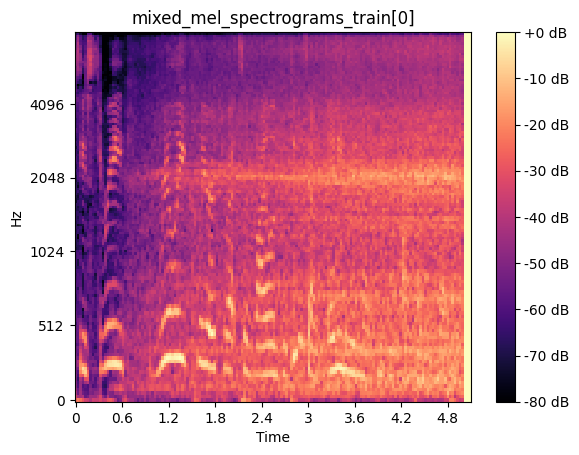

In [7]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mixed_mel_spectrograms_train[0][0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='mixed_mel_spectrograms_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "mixed_mel_spectrograms_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

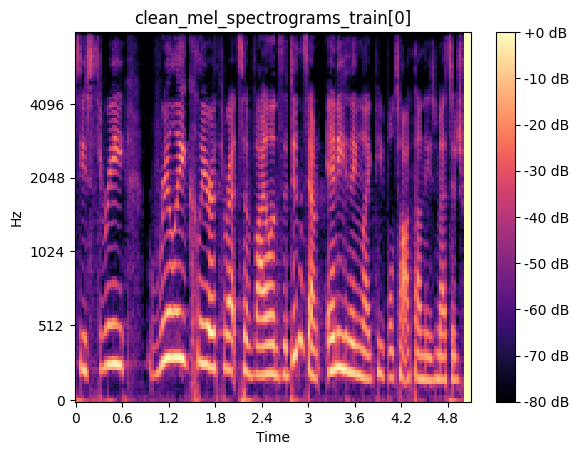

In [8]:
fig, ax = plt.subplots()
img = librosa.display.specshow(clean_mel_spectrograms_train[0][0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='clean_mel_spectrograms_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "clean_mel_spectrograms_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

### Training

In [9]:
class DenoiseAutoencoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoencoder, self).__init__()
        # 編碼器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # 全連接層 ### shape 有問題
        self.fc1 = nn.Linear(10240, 256)  # 假設輸入大小為 (1, 64, 64)
        self.fc2 = nn.Linear(256, 10240)

        # 解碼器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # 編碼器
        x = self.encoder(x)
        
        # 將特徵展平
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        # 全連接層處理
        x = self.fc1(x)
        x = self.fc2(x)
        
        # 恢復形狀為解碼器輸入
        x = x.view(batch_size, 128, 8, 10)
        # 解碼器
        x = self.decoder(x)
        return x

In [13]:
# Model參數
num_epochs = 100
batch_size = 256
learning_rate = 0.5
lr_decay_step = 20
lr_decay_gamma = 0.7

In [14]:
class AudioDataset(Dataset):
    def __init__(self, mixed_data, clean_data):
        self.mixed = mixed_data
        self.clean = clean_data
    
    def __len__(self):
        return len(self.mixed)
    
    def __getitem__(self, idx):
        return self.mixed[idx], self.clean[idx]

dataset = AudioDataset(mixed_mel_spectrograms_train, clean_mel_spectrograms_train)
dataloader = DataLoader(dataset, batch_size=batch_size)
dataloader_val = DataLoader(AudioDataset(mixed_mel_spectrograms_val, clean_mel_spectrograms_val), batch_size=len(mixed_mel_spectrograms_val))


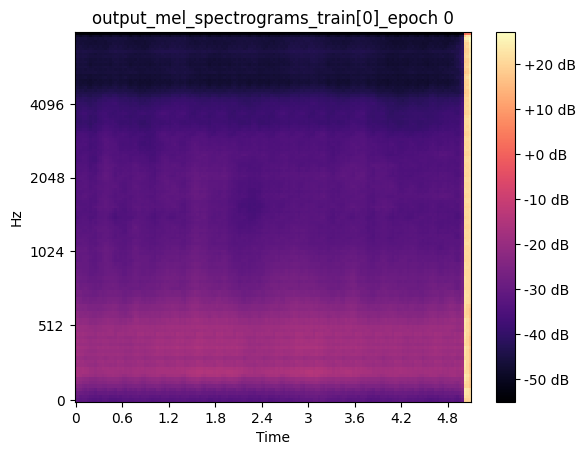

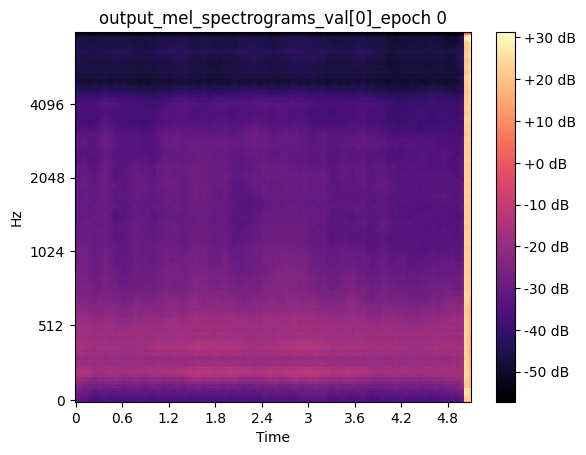

Epoch [1/100], Training Loss: 691.638122558594, Validation Loss: 597.884155273438, Learning Rate: 0.50000000
Epoch [2/100], Training Loss: 180.474609375000, Validation Loss: 177.238571166992, Learning Rate: 0.50000000
Epoch [3/100], Training Loss: 109.017913818359, Validation Loss: 97.429031372070, Learning Rate: 0.50000000
Epoch [4/100], Training Loss: 65.047752380371, Validation Loss: 66.022628784180, Learning Rate: 0.50000000
Epoch [5/100], Training Loss: 43.887710571289, Validation Loss: 49.806098937988, Learning Rate: 0.50000000
Epoch [6/100], Training Loss: 34.038368225098, Validation Loss: 42.554664611816, Learning Rate: 0.50000000
Epoch [7/100], Training Loss: 27.982637405396, Validation Loss: 39.015106201172, Learning Rate: 0.50000000
Epoch [8/100], Training Loss: 24.180107116699, Validation Loss: 35.653350830078, Learning Rate: 0.50000000
Epoch [9/100], Training Loss: 21.369728088379, Validation Loss: 34.807685852051, Learning Rate: 0.50000000
Epoch [10/100], Training Loss: 1

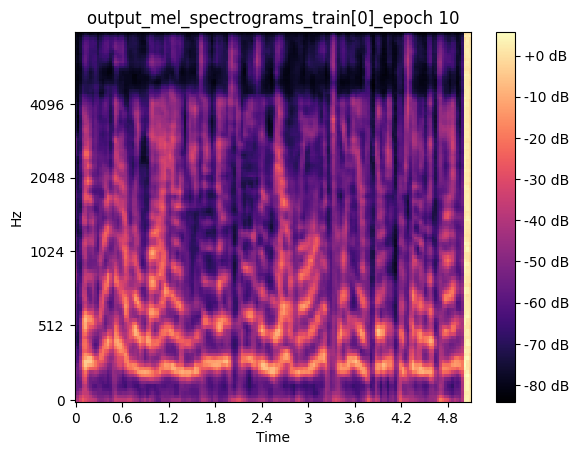

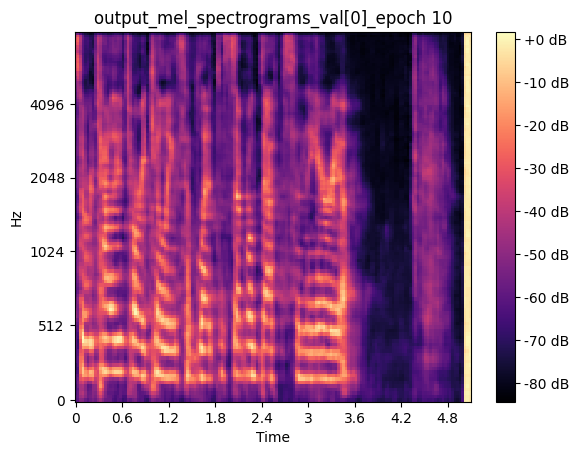

Epoch [11/100], Training Loss: 17.992343902588, Validation Loss: 30.303165435791, Learning Rate: 0.50000000
Epoch [12/100], Training Loss: 16.850879669189, Validation Loss: 29.405084609985, Learning Rate: 0.50000000
Epoch [13/100], Training Loss: 15.882190704346, Validation Loss: 28.723464965820, Learning Rate: 0.50000000
Epoch [14/100], Training Loss: 15.130101203918, Validation Loss: 27.773761749268, Learning Rate: 0.50000000
Epoch [15/100], Training Loss: 14.356081962585, Validation Loss: 26.896762847900, Learning Rate: 0.50000000
Epoch [16/100], Training Loss: 13.683938026428, Validation Loss: 26.910640716553, Learning Rate: 0.50000000
Epoch [17/100], Training Loss: 13.173483848572, Validation Loss: 26.291967391968, Learning Rate: 0.50000000
Epoch [18/100], Training Loss: 12.731243133545, Validation Loss: 25.728445053101, Learning Rate: 0.50000000
Epoch [19/100], Training Loss: 12.312563896179, Validation Loss: 25.582883834839, Learning Rate: 0.50000000
Epoch [20/100], Training Los

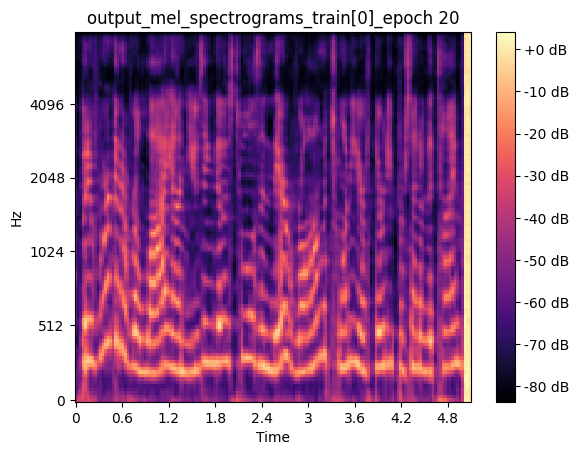

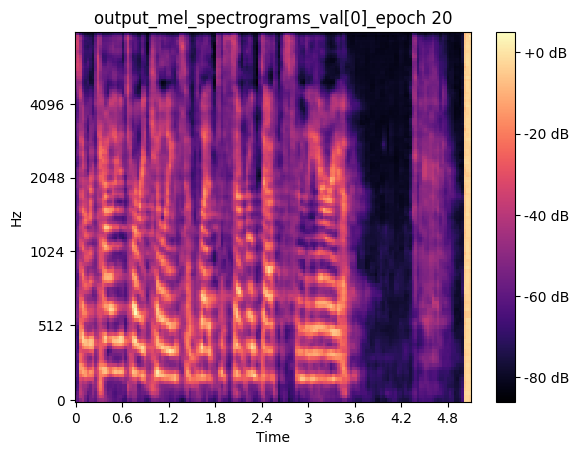

Epoch [21/100], Training Loss: 11.671877861023, Validation Loss: 24.111907958984, Learning Rate: 0.35000000
Epoch [22/100], Training Loss: 11.277419090271, Validation Loss: 23.949840545654, Learning Rate: 0.35000000
Epoch [23/100], Training Loss: 11.027840614319, Validation Loss: 23.545488357544, Learning Rate: 0.35000000
Epoch [24/100], Training Loss: 10.831852912903, Validation Loss: 23.301177978516, Learning Rate: 0.35000000
Epoch [25/100], Training Loss: 10.668138504028, Validation Loss: 22.871686935425, Learning Rate: 0.35000000
Epoch [26/100], Training Loss: 10.528156280518, Validation Loss: 22.723196029663, Learning Rate: 0.35000000
Epoch [27/100], Training Loss: 10.283655166626, Validation Loss: 22.490236282349, Learning Rate: 0.35000000
Epoch [28/100], Training Loss: 10.076585769653, Validation Loss: 22.092761993408, Learning Rate: 0.35000000
Epoch [29/100], Training Loss: 9.906654357910, Validation Loss: 22.046493530273, Learning Rate: 0.35000000
Epoch [30/100], Training Loss

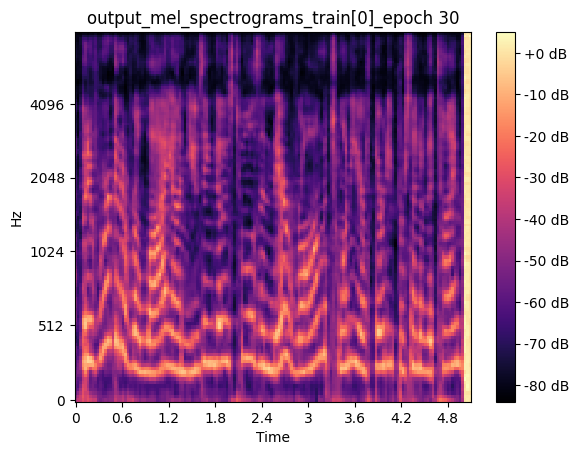

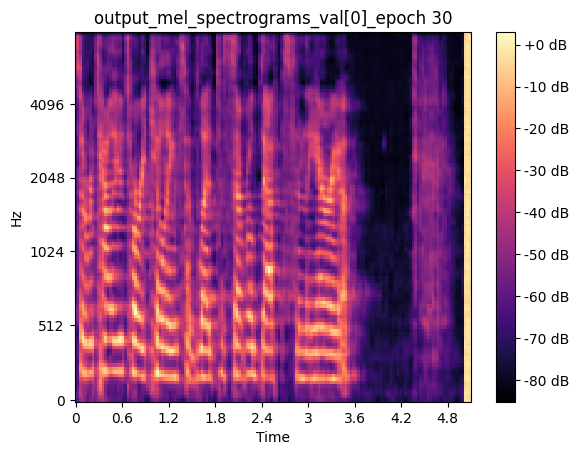

Epoch [31/100], Training Loss: 9.653690338135, Validation Loss: 22.541711807251, Learning Rate: 0.35000000
Epoch [32/100], Training Loss: 9.550324440002, Validation Loss: 22.655223846436, Learning Rate: 0.35000000
Epoch [33/100], Training Loss: 9.437726974487, Validation Loss: 22.447507858276, Learning Rate: 0.35000000
Epoch [34/100], Training Loss: 9.451606750488, Validation Loss: 21.893764495850, Learning Rate: 0.35000000
Epoch [35/100], Training Loss: 9.376594543457, Validation Loss: 21.457248687744, Learning Rate: 0.35000000
Epoch [36/100], Training Loss: 9.182375907898, Validation Loss: 20.900730133057, Learning Rate: 0.35000000
Epoch [37/100], Training Loss: 9.060461044312, Validation Loss: 21.567850112915, Learning Rate: 0.35000000
Epoch [38/100], Training Loss: 8.959519386292, Validation Loss: 21.240238189697, Learning Rate: 0.35000000
Epoch [39/100], Training Loss: 9.207503318787, Validation Loss: 21.616077423096, Learning Rate: 0.35000000
Epoch [40/100], Training Loss: 8.9057

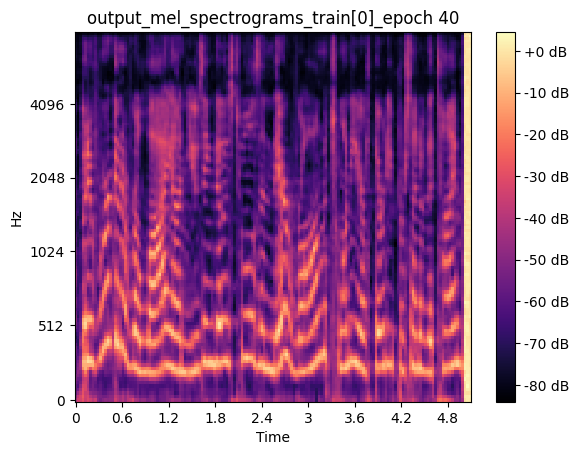

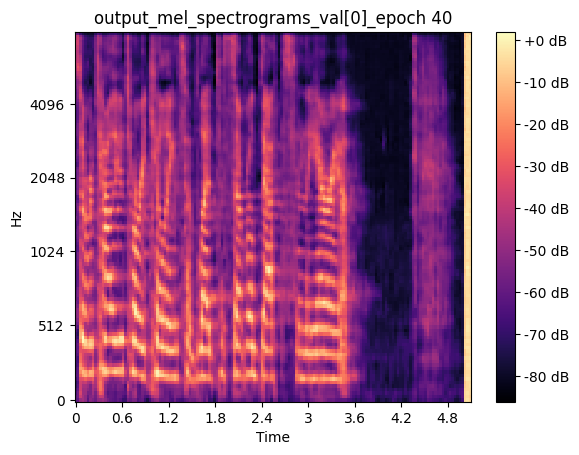

Epoch [41/100], Training Loss: 8.644731521606, Validation Loss: 20.594722747803, Learning Rate: 0.24500000
Epoch [42/100], Training Loss: 8.432778358459, Validation Loss: 20.507045745850, Learning Rate: 0.24500000
Epoch [43/100], Training Loss: 8.327877044678, Validation Loss: 20.418716430664, Learning Rate: 0.24500000
Epoch [44/100], Training Loss: 8.237648963928, Validation Loss: 20.299404144287, Learning Rate: 0.24500000
Epoch [45/100], Training Loss: 8.168429374695, Validation Loss: 20.241531372070, Learning Rate: 0.24500000
Epoch [46/100], Training Loss: 8.111745834351, Validation Loss: 20.232295989990, Learning Rate: 0.24500000
Epoch [47/100], Training Loss: 8.081489562988, Validation Loss: 20.307794570923, Learning Rate: 0.24500000
Epoch [48/100], Training Loss: 8.106953620911, Validation Loss: 20.315332412720, Learning Rate: 0.24500000
Epoch [49/100], Training Loss: 8.115440368652, Validation Loss: 20.527000427246, Learning Rate: 0.24500000
Epoch [50/100], Training Loss: 8.3095

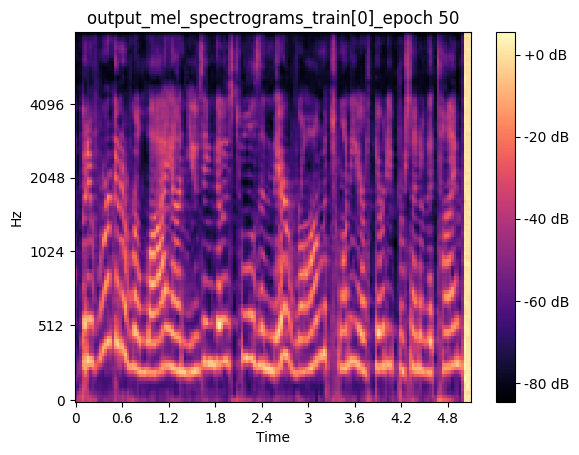

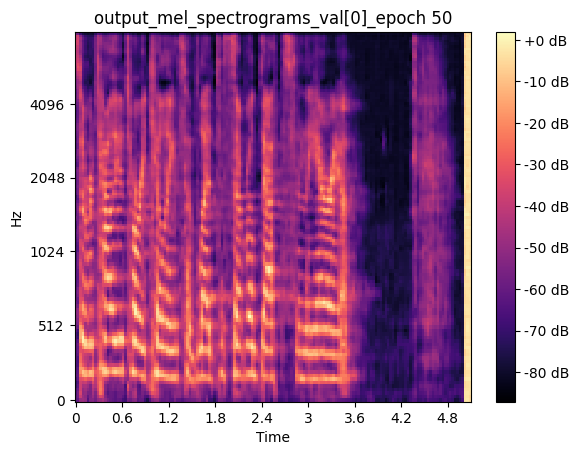

Epoch [51/100], Training Loss: 9.117164611816, Validation Loss: 21.213857650757, Learning Rate: 0.24500000
Epoch [52/100], Training Loss: 8.003161430359, Validation Loss: 20.600975036621, Learning Rate: 0.24500000
Epoch [53/100], Training Loss: 7.813986778259, Validation Loss: 20.449075698853, Learning Rate: 0.24500000
Epoch [54/100], Training Loss: 7.704144477844, Validation Loss: 20.218664169312, Learning Rate: 0.24500000
Epoch [55/100], Training Loss: 7.625009536743, Validation Loss: 20.215328216553, Learning Rate: 0.24500000
Epoch [56/100], Training Loss: 7.519917011261, Validation Loss: 20.043609619141, Learning Rate: 0.24500000
Epoch [57/100], Training Loss: 7.451960563660, Validation Loss: 20.046115875244, Learning Rate: 0.24500000
Epoch [58/100], Training Loss: 7.373238563538, Validation Loss: 20.110731124878, Learning Rate: 0.24500000
Epoch [59/100], Training Loss: 7.306703567505, Validation Loss: 20.248550415039, Learning Rate: 0.24500000
Epoch [60/100], Training Loss: 7.2542

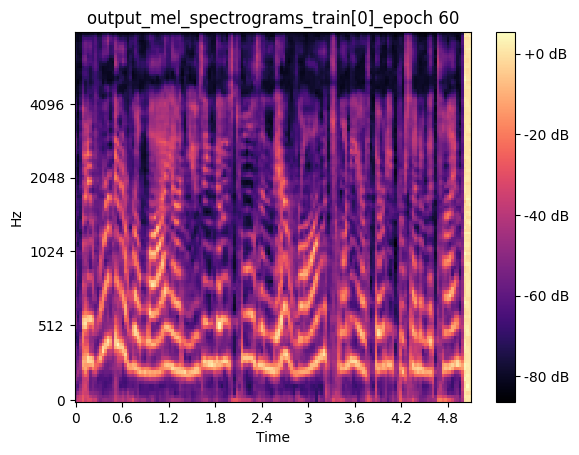

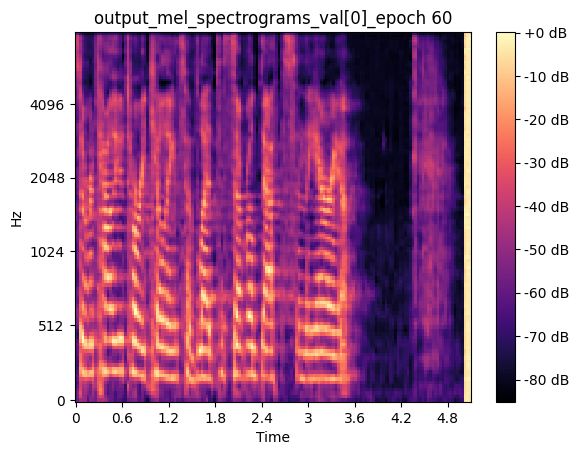

Epoch [61/100], Training Loss: 7.237347602844, Validation Loss: 21.303735733032, Learning Rate: 0.17150000
Epoch [62/100], Training Loss: 7.161483287811, Validation Loss: 21.812295913696, Learning Rate: 0.17150000
Epoch [63/100], Training Loss: 7.122622013092, Validation Loss: 21.968242645264, Learning Rate: 0.17150000
Epoch [64/100], Training Loss: 7.045502185822, Validation Loss: 21.726675033569, Learning Rate: 0.17150000
Epoch [65/100], Training Loss: 6.973218441010, Validation Loss: 21.975379943848, Learning Rate: 0.17150000
Epoch [66/100], Training Loss: 6.942670822144, Validation Loss: 21.651626586914, Learning Rate: 0.17150000
Epoch [67/100], Training Loss: 6.936624050140, Validation Loss: 21.956193923950, Learning Rate: 0.17150000
Epoch [68/100], Training Loss: 6.866659164429, Validation Loss: 22.217756271362, Learning Rate: 0.17150000
Epoch [69/100], Training Loss: 6.790564537048, Validation Loss: 22.241909027100, Learning Rate: 0.17150000
Epoch [70/100], Training Loss: 6.7884

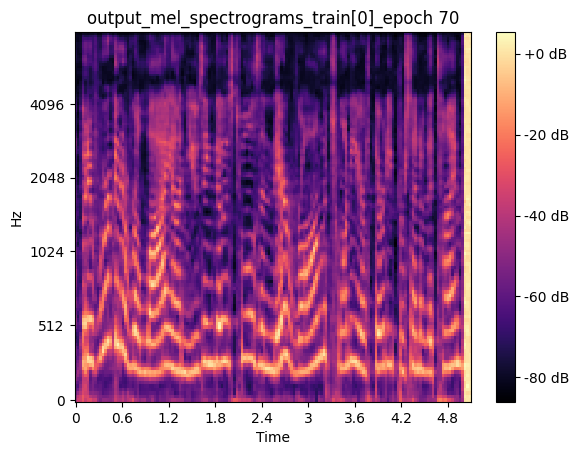

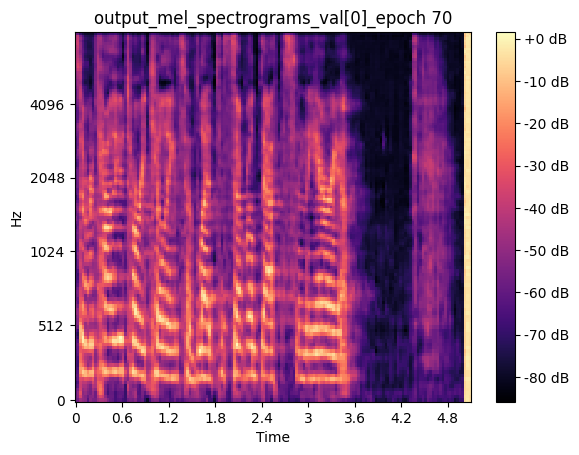

Epoch [71/100], Training Loss: 6.731679916382, Validation Loss: 22.811916351318, Learning Rate: 0.17150000
Epoch [72/100], Training Loss: 6.707727432251, Validation Loss: 21.668697357178, Learning Rate: 0.17150000
Epoch [73/100], Training Loss: 6.657131195068, Validation Loss: 21.627872467041, Learning Rate: 0.17150000
Epoch [74/100], Training Loss: 6.608314990997, Validation Loss: 21.640302658081, Learning Rate: 0.17150000
Epoch [75/100], Training Loss: 6.595350742340, Validation Loss: 21.489208221436, Learning Rate: 0.17150000
Epoch [76/100], Training Loss: 6.555787563324, Validation Loss: 20.465366363525, Learning Rate: 0.17150000
Epoch [77/100], Training Loss: 6.527550220490, Validation Loss: 21.121715545654, Learning Rate: 0.17150000
Epoch [78/100], Training Loss: 6.530668258667, Validation Loss: 20.953805923462, Learning Rate: 0.17150000
Epoch [79/100], Training Loss: 6.475884914398, Validation Loss: 20.830848693848, Learning Rate: 0.17150000
Epoch [80/100], Training Loss: 6.4265

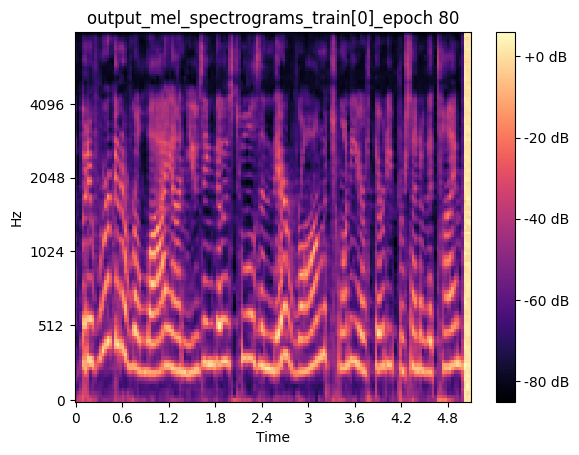

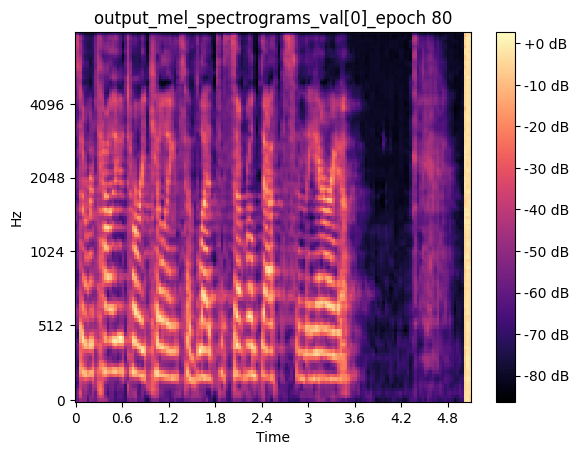

Epoch [81/100], Training Loss: 6.400932788849, Validation Loss: 21.458995819092, Learning Rate: 0.12005000
Epoch [82/100], Training Loss: 6.256220817566, Validation Loss: 21.337450027466, Learning Rate: 0.12005000
Epoch [83/100], Training Loss: 6.248404026031, Validation Loss: 21.230785369873, Learning Rate: 0.12005000
Epoch [84/100], Training Loss: 6.225492477417, Validation Loss: 21.317476272583, Learning Rate: 0.12005000
Epoch [85/100], Training Loss: 6.159536361694, Validation Loss: 21.420330047607, Learning Rate: 0.12005000
Epoch [86/100], Training Loss: 6.123437881470, Validation Loss: 21.012409210205, Learning Rate: 0.12005000
Epoch [87/100], Training Loss: 6.080679893494, Validation Loss: 20.554632186890, Learning Rate: 0.12005000
Epoch [88/100], Training Loss: 6.055188655853, Validation Loss: 20.254970550537, Learning Rate: 0.12005000
Epoch [89/100], Training Loss: 6.028154373169, Validation Loss: 19.922143936157, Learning Rate: 0.12005000
Epoch [90/100], Training Loss: 6.0103

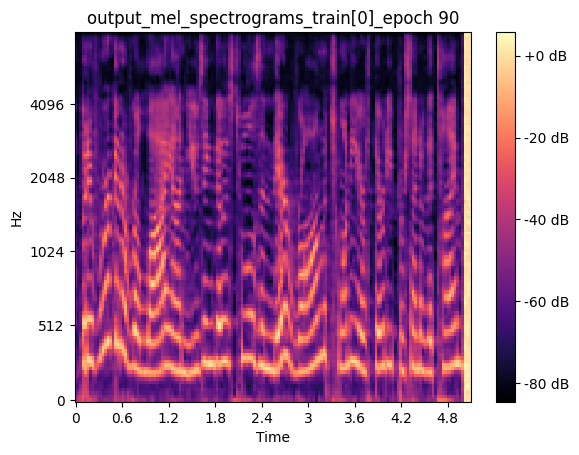

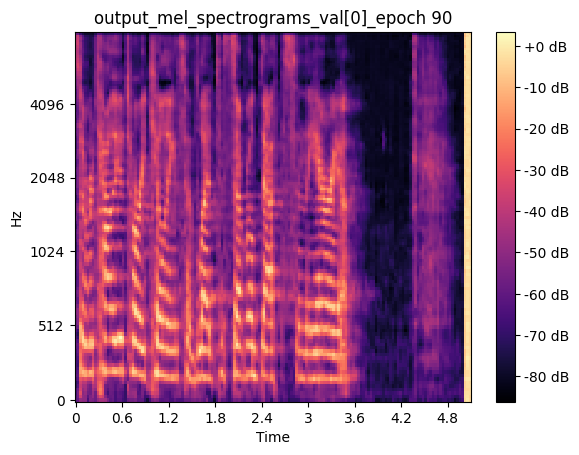

Epoch [91/100], Training Loss: 5.994028091431, Validation Loss: 19.161533355713, Learning Rate: 0.12005000
Epoch [92/100], Training Loss: 5.966458797455, Validation Loss: 19.397624969482, Learning Rate: 0.12005000
Epoch [93/100], Training Loss: 5.933948993683, Validation Loss: 19.350662231445, Learning Rate: 0.12005000
Epoch [94/100], Training Loss: 5.908805370331, Validation Loss: 19.147653579712, Learning Rate: 0.12005000
Epoch [95/100], Training Loss: 5.887519359589, Validation Loss: 19.275707244873, Learning Rate: 0.12005000
Epoch [96/100], Training Loss: 5.853042125702, Validation Loss: 18.938831329346, Learning Rate: 0.12005000
Epoch [97/100], Training Loss: 5.849044322968, Validation Loss: 18.887392044067, Learning Rate: 0.12005000
Epoch [98/100], Training Loss: 5.846485614777, Validation Loss: 18.799060821533, Learning Rate: 0.12005000
Epoch [99/100], Training Loss: 5.864542007446, Validation Loss: 18.539505004883, Learning Rate: 0.12005000
Epoch [100/100], Training Loss: 5.830

In [15]:
from torch.optim.lr_scheduler import StepLR
import gc
model = DenoiseAutoencoder()

# torchsummary.summary(model,(1,64,44))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)
training_losses = []
validation_losses = []
training_snrs = []
validation_snrs = []
train_input = torch.tensor(np.array([mixed_mel_spectrograms_train[0]]), dtype=torch.float32)
train_clean = torch.tensor(np.array([clean_mel_spectrograms_train[0]]), dtype=torch.float32)
val_input = torch.tensor(np.array([mixed_mel_spectrograms_val[0]]), dtype=torch.float32)
val_clean = torch.tensor(np.array([clean_mel_spectrograms_val[0]]), dtype=torch.float32)

# 訓練過程
for epoch in range(num_epochs):
    model.train()
    sum_loss = 0
    for (mixed, clean) in dataloader:
        
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(mixed)
        loss = criterion(outputs, clean)
        sum_loss += loss.item()
            
        # 反向傳播和優化
        loss.backward()
        optimizer.step()
        
    # Step the scheduler to decay the learning rate
    scheduler.step()
    
    # count training loss and SNR
    snr = calculate_snr(clean, outputs)
    training_losses.append(sum_loss / len(dataloader))
    training_snrs.append(snr)
    
    if epoch % 10 == 0:
        fig, ax = plt.subplots()
        img = librosa.display.specshow(outputs[0][0].detach().cpu().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title=f'output_mel_spectrograms_train[0]_epoch {epoch}')
        plt.show()

        # 將圖像保存至檔案
        output_path = test_dir['visual'] + f'output_mel_spectrograms_train[0]_epoch {epoch}'  # 定義保存的檔案名稱和格式
        fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
        plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())
        gc.collect()
    
    # count validation loss and SNR
    val_output = model(val_input)
    val_loss = criterion(val_output, val_clean)
    val_snr = calculate_snr(val_clean, val_output)
    validation_losses.append(val_loss.item())
    validation_snrs.append(val_snr)
    
    if epoch % 10 == 0:
        fig, ax = plt.subplots()
        img = librosa.display.specshow(val_output[0][0].detach().cpu().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title=f'output_mel_spectrograms_val[0]_epoch {epoch}')
        plt.show()

        # 將圖像保存至檔案
        output_path = test_dir['visual'] + f'output_mel_spectrograms_val[0]_epoch {epoch}'  # 定義保存的檔案名稱和格式
        fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
        plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())
        gc.collect()
    
    # Optionally, print the current learning rate and loss
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.12f}, Validation Loss: {val_loss.item():.12f}, Learning Rate: {current_lr:.8f}")

### Plot Loss

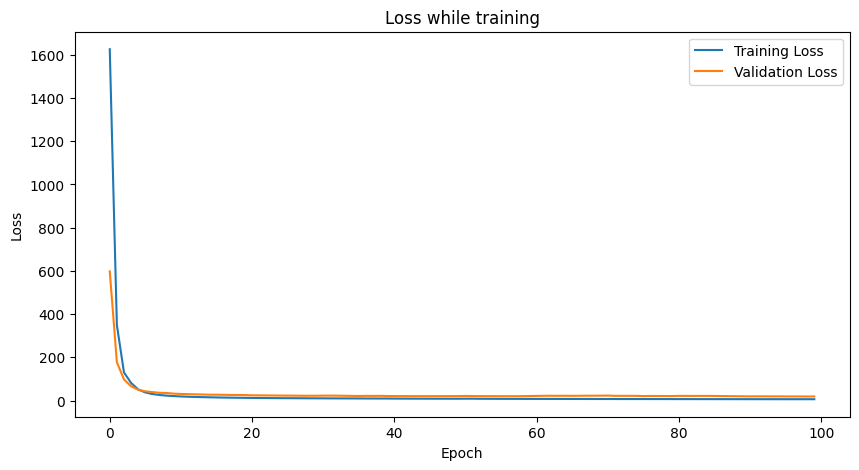

In [16]:
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.title("Loss while training")
# plt.xlim([5, num_epochs])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "loss_while_training.png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

### Plot SNR

Training SNR:   26.57819557 dB
Validation SNR: 24.73653412 dB


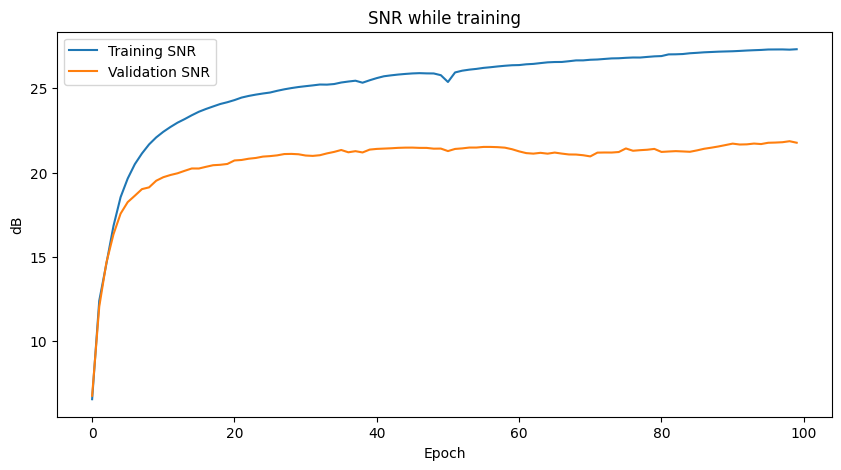

In [17]:
# print the SNR of the first training sample
model.eval()

with torch.no_grad():
    train_output = model(train_input)
    snr = calculate_snr(train_clean, train_output)
    print(f"Training SNR:   {snr:.8f} dB")

with torch.no_grad():
    val_output = model(val_input)
    snr = calculate_snr(val_clean, val_output)
    print(f"Validation SNR: {snr:.8f} dB")
    
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_snrs, label="Training SNR")
plt.plot(validation_snrs, label="Validation SNR")
plt.title("SNR while training")
plt.xlabel("Epoch")
plt.ylabel("dB")
plt.legend()
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "snr_while_training.png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

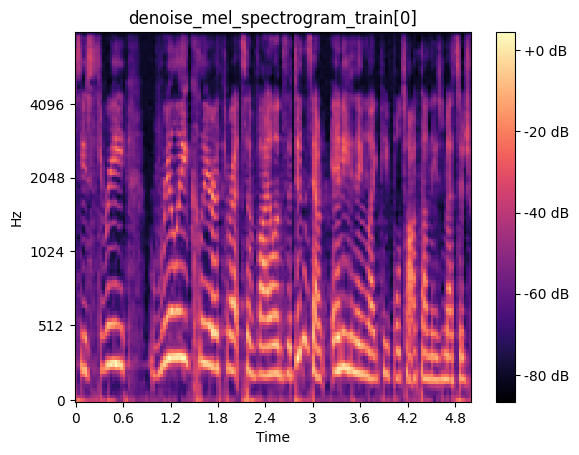

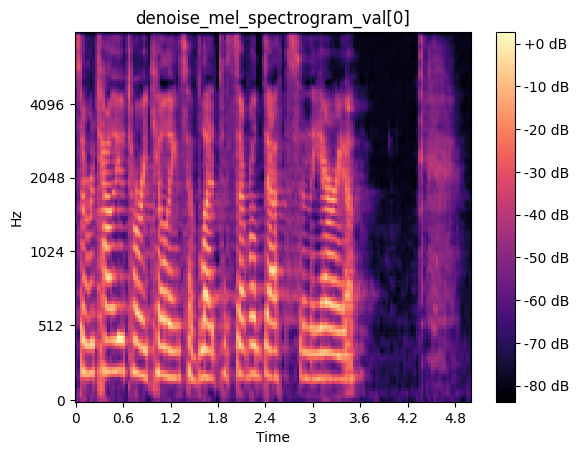

In [18]:
model.eval()

denoised_output = model(torch.from_numpy(mixed_mel_spectrograms_train[0]).unsqueeze(0))
denoised_output = denoised_output[:, :, :, :157]
fig, ax = plt.subplots()
img = librosa.display.specshow(denoised_output.squeeze(0).squeeze(0).detach().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='denoise_mel_spectrogram_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "denoise_mel_spectrogram_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

denoised_output = model(torch.from_numpy(mixed_mel_spectrograms_val[0]).unsqueeze(0))
denoised_output = denoised_output[:, :, :, :157]
fig, ax = plt.subplots()
img = librosa.display.specshow(denoised_output.squeeze(0).squeeze(0).detach().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='denoise_mel_spectrogram_val[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "denoise_mel_spectrogram_val[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

### Prediction

In [19]:
# # MelSpectrogram參數 (勿動)
# n_mels = 128                # 保持 Mel 頻譜圖的解析度
# n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
# hop_length = 512            # 保持 hop_length 為 n_fft 的一半
# win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
# sample_rate = 16000         # 採樣率保持不變，適合語音處理
# f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
# duration = 5                # 音頻時長為 5 秒

In [20]:
# # MIXED
# mixed_waveform, sample_rate = librosa.load('test2.wav', sr=sample_rate)

# # if sr != sample_rate:
# #     mixed_waveform = librosa.resample(mixed_waveform, orig_sr=sr, target_sr=sample_rate)
    
# # cut to fit the duration
# if len(mixed_waveform) > sample_rate * duration:
#     mixed_waveform = mixed_waveform[:sample_rate * duration]

# mixed_mel_spectrogram = librosa.feature.melspectrogram(
#     y=mixed_waveform,
#     sr=sample_rate,
#     n_fft=n_fft,
#     hop_length=hop_length,
#     n_mels=n_mels
# )

# mixed_mel_spectrogram_db = librosa.power_to_db(
#     mixed_mel_spectrogram, 
#     ref=np.max, 
#     amin=1e-10  # 避免log(0)
# )

# # mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram, dtype=torch.float32).squeeze().unsqueeze(0)
# mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
# # mixed_mel_tensor = torch.tensor(np.load('nature_mixed.npy'), dtype=torch.float32).squeeze().unsqueeze(0)

# mixed_mel = mixed_mel_tensor
# mixed_output = mixed_mel.squeeze(0).squeeze(0).detach().numpy()
# mixed_output = librosa.db_to_power(mixed_output)

# audio_signal = librosa.feature.inverse.mel_to_audio(
#     mixed_output,
#     sr=sample_rate,
#     n_fft=n_fft,
#     hop_length=hop_length,
#     n_iter=512
# )

# audio_signal = audio_signal / np.max(np.abs(audio_signal))


# librosa.display.waveshow(audio_signal, sr=sample_rate)
# soundfile.write('test_librosa_mixed.wav', audio_signal, sample_rate)

In [21]:
# # DENOISED
# model.eval()  # 设置模型为评估模式
# # print(mixed_mel_tensor.shape)
# print(test_mixed_mel_spectrograms[0].shape)
# mixed_mel_np_array = np.array(test_mixed_mel_spectrograms)
# for i in range(len(mixed_mel_np_array)):
#     mixed_mel_np_array[i] = mixed_mel_np_array[i][:, :, :157]
# print(mixed_mel_np_array.shape)

# mixed_mel_tensor = torch.tensor(mixed_mel_np_array, dtype=torch.float32)

# denoised_output = model(mixed_mel_tensor)
# denoised_output = denoised_output[:, :, :, :157]
# print(denoised_output.shape)
# denoised_output = denoised_output.squeeze(0).squeeze(0).detach().numpy()
# denoised_output = librosa.db_to_power(denoised_output)

# audio_signal = librosa.feature.inverse.mel_to_audio(denoised_output, sr=sample_rate, n_iter=500)
# audio_signal = audio_signal / np.max(np.abs(audio_signal))

# librosa.display.waveshow(audio_signal, sr=sample_rate)
# soundfile.write('test_librosa_denoised.wav', audio_signal, sample_rate)
